<a href="https://colab.research.google.com/github/mihaitudor9/met_collection_cleaning/blob/main/Metropolitan_Museum_Art_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The point of this project is to retrieve a "dirty" dataset available online and come up with a few research objectives that could be achieved after the EDA procedures. The task also requires comparing two studied algorithms (e.g., regression, classification, DR, etc.) employing the retrieved dataset.**

# Findings ways of improvements of the collection of paintings and drawings in the Metropolitan Museum Of Art

Natalia Guseva

Paula Gitu

Mihai Tudor


Maastricht University 2021

Data Analysis(KEN 3450)

2021

# Ethical Considerations

1. **Source of the dataset:** The dataset has been downloaded from Github: https://github.com/metmuseum/openaccess

2. **How the dataset was created ?** The dataset looks like the result of scraping. A short look at https://www.metmuseum.org/art/collection/search/436532 shall prove that the info in each field in of .csv file originates from the metmuseum.org website.
3.  There are plenty of meaningful insights from this analysis we performed. However, it was almost impossible to think of a practical yet quality prediction model. Moreover, as stated in due time, we might have encountered specific problems precisely answering the research question we mentioned in the project proposal. Still, given our updated knowledge about the dataset, we quickly reoriented and found other aspects to focus on. 

4. **Did you make decisions that affect the analysis?** Certainly, plenty of items had missing or unusable essential fields (i.e., dimensions, year of completion, or country). Therefore, several items had to be deleted, or specific analyses such as geographical ones had to be conducted on very tiny subsets of the complete data.


5. Due to an extreme variety in text fields, a complete clean-up, and analysis of all object types were impossible to perform on a dataset containing all 100K items. Therefore, our analysis focused only on the drawings and paintings within the dataset.

6. **The main stakeholder of our project is the museum itself**. As evoked in the project proposal, a museum as famous as Met Museum in NY shall have detailed statistics of all stored items. 

  
  6.1. They should be completely aware of where most of their items originate from or, in contrast, which country or region is missing items from. 
  
  6.2. Likewise, a museum should have competent statistics over how diverse the nationalities of the artists being displayed there are. 
  
  6.3. Last but not least, such a famous museum shall perform concrete statistics on the available market before deciding on extending an existing wing of the museum or building an additional one to incorporate the artwork to arrive in the coming years.

7. **Who can benefit from this project?** Artists from countries that are not very well represented in the collection or even items completed in a specific year where very few other artworks were completed.
The possible visitors might benefit from this project as well. Such statistics could be released to the public such that any potential visitor is thoroughly informed of the overall source of articles. Certain visitors might be more fascinated by the artwork being inspired and created in the early 17th century or the 1920s. The satistical results, showing that those periods might be well represented in the Met Collection, can influence the visitors to visit as soon as possible.

In [ ]:
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.formula.api as sm
import re
from numpy import arange
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

sns.set_theme(style="darkgrid")
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)

# Displaying all values of the dataframe if necessary
#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
# Due to mixed values, we will be treating most fields as a text for now and see if there
# is anything to be done such that numerical values could be extracted out of these.
# There are, however, a few Boolean and Numerical types exceptions.

df = pd.read_csv("MetObjects.txt", dtype={
    'Gallery Number': str, 'Period': str,
    'Portfolio': str,
    'Dimensions': str
    }, low_memory=False)

For the first part of our analysis, we would like to focus on the **Paintings** and **Drawings**. Indeed, there are many similarities between these two types of artworks, and we will study these throughout the notebook and the differences.

In [ ]:
# For this 1st part of the analysis, we are only interested in the
# paintings and drawings
df = df.loc[df['Classification'].isin(['Paintings', 'Drawings'])]

While the complete list of columns is much larger, there was plenty of redundant information within the columns. (e.g., two columns were representing the ID)

In [ ]:
# Re-order the columns such that <Object ID> is the first column.
# Other reorders should follow
df = df[
    ['Object ID', 'Department', 'AccessionYear', 'Object Name', 'Title', 'Culture',
     'Reign', 'Artist Display Name', 'Artist Nationality', 'Artist Begin Date', 'Artist End Date',
     'Artist Wikidata URL',
     'Object Begin Date', 'Object End Date', 'Medium', 'Dimensions',
     'City', 'Country', 'Classification', 'Object Wikidata URL', 'Tags']]

As much as we enjoyed performing geographical analysis on the data, the **"Country"** variable is missing for 98% of the items. Therefore, answering questions such as "Do we need items from a certain Country or Region to have a complete and submerging experience in our museum" remains relatively unanswered. However, we will perform some analysis on that 2% just to get an idea of where most items could be originating from, without stating that such an analysis is pertinent. 

Even though the **"Artist Nationality"** is present in 85% of the items, we will see that it is almost impossible to extract any relevant geographical info from that feature.

The **"Reign"** variable seems missing from all items. Therefore, that column will get deleted. Similarly, there are only many items containing the **"City"** field.

In [ ]:
# Number of rows that have a value NaN
for column in df:
    print(column, len(df[pd.isnull(df[column])]), "/", len(df['Object ID']))

del df['Reign']
del df['City']

Object ID 0 / 36280
Department 0 / 36280
AccessionYear 90 / 36280
Object Name 25 / 36280
Title 2220 / 36280
Culture 26912 / 36280
Reign 36280 / 36280
Artist Display Name 1273 / 36280
Artist Nationality 5793 / 36280
Artist Begin Date 4879 / 36280
Artist End Date 4865 / 36280
Artist Wikidata URL 8727 / 36280
Object Begin Date 0 / 36280
Object End Date 0 / 36280
Medium 301 / 36280
Dimensions 706 / 36280
City 36188 / 36280
Country 35597 / 36280
Classification 0 / 36280
Object Wikidata URL 25603 / 36280
Tags 6957 / 36280


In [ ]:
# Clean up of the Culture column
df['Culture'] = df['Culture'].str.replace('for export', '')
df['Culture'] = df['Culture'].str.replace(', for Swedish market', ' (Swedish market)')
df['Culture'] = df['Culture'].str.replace(', for American market', ' (American market)')
df['Culture'] = df['Culture'].str.replace('or', ',')
df['Culture'] = df['Culture'].str.replace(', probably', '')
df['Culture'] = df['Culture'].str.replace(', possibly', '')
df['Culture'] = df['Culture'].str.replace('probably', '')

# There is some evident redundancy in the Culture and Country fields as well as some typos
df['Culture'] = df['Culture'].str.replace('(Veneto)', 'Veneto')
df['Culture'] = df['Culture'].str.replace('K,ea', 'K,ea, Japan')
df['Culture'] = df['Culture'].str.replace('Fl,ence', 'Florence')

# USA -> United States
# US -> United States
# The United States -> United States
df['Country'] = df['Country'].str.replace('USA', 'United States')
df['Country'] = df['Country'].str.replace('US', 'United States')
df['Country'] = df['Country'].str.replace('The United States', 'United States')

In [ ]:
df.loc[:, 'Covered Area'] = -1

Apart from missing values in the **'Dimensions'** field, we notice other types of inadequately inserted dimensions.

A big part of our analysis focused on the dimensions. As a result of this, we will be cleaning the items with unworkable dimensions such as:
unavailable, irregular, trimmed, with base, N.A, trimmed to a plate or other types from which we could not extract usable dimensions

In [ ]:
df = df[df['Dimensions'].notna()]
# Originally, the dimensions of each object were stored both in inches and centimeters
# Should only keep the centimeters dimensions written within the () brackets
# i.e. 15 3/4 x 11 3/4 in. (40 x 29.8 cm) - > 40 x 29.8
# keeping in mind that the resulting column will denote the dimensions in CM
df['Dimensions'] = df['Dimensions'].apply(lambda st: st[st.find("(") + 1:st.find(")")])
df['Dimensions'] = (df['Dimensions'].str.replace("cm", ""))
df['Dimensions'] = (df['Dimensions'].str.replace(" ", ""))
df['Dimensions'] = (df['Dimensions'].str.replace("×", "x"))

In [ ]:
# below, we look for each object's dimensions, and if it does not contain a digit, we delete it
for index, dimensions in enumerate(df['Dimensions']):
    string = df.iloc[index]['Dimensions']
    nr_d = 0
    for c in string:
        if c.isdigit():
            nr_d += 1
    if (nr_d == 0): # if the dimensions contain no digit
        df.at[index, 'Dimensions'] = 'DELETE' # mark the item

df = df[~df['Dimensions'].str.contains("DELETE", na=False)]

Plenty of the columns contains multiple variables. Still, it is rather confusing that these variables are separated differently depending on the column. Surely, we would like a standardized version in order to reduce the confusion

In [ ]:
# Standardizing the multiple column columns such that the variables look like 'Tags' instead
df['Medium'] = df['Medium'].str.lower()
df['Medium'] = (df['Medium'].str.replace(", ", "|"))
df['Artist Nationality'] = (df['Artist Nationality'].str.replace(", ", "|"))

In [ ]:
# It might not be the best idea to split the <Dimensions> column into <Width> and <Length> features.
# As expected, the dataset contains both 2-dimensional and 3-dimensional items
# We already mentioned that our analysis would focus on the Drawings and Paintings within the dataset,
# hence we will be interested in 2-dimensional items.

# A simple count of the 'x' symbol will tell us whether the item is 2-dimensional or not.
# (e.g. 1 x 5.3 VS 2 x 4 x 8)
df['Dimensionality'] = df['Dimensions'].apply(lambda st: str.count(st, "x") + 1)

There are quite a lot of items like **Coins** being listed by their diameter instead of the Width and Length.
We can quickly fix these by duplicating the diameter value such that the **'Covered Area'** field will be correctly computed.


In [ ]:
for index, (dimensionality, dimensions) in enumerate(zip(df['Dimensionality'], df['Dimensions'])):
    if (df.iloc[index]['Dimensionality']) == 1:
        df.at[index, 'Dimensionality'] = 2
        df.at[index, 'Dimensions'] = df.iloc[index]['Dimensions'] + "x" + df.iloc[index]['Dimensions']

In [ ]:
# count the total covered area of each 2-dimensional item in the remaining subset
for index_item, item in df.iterrows():

    if (df['Dimensionality'][index_item] == 2):
        number_dimensions = []
        text_dimension = df['Dimensions'][index_item]
        number_dimensions = [float(s) for s in re.findall(r'-?\d+\.?\d*', text_dimension)]

        covered_area = np.prod(np.array(number_dimensions))
        df['Covered Area'][index_item] = covered_area

In [ ]:
# convert columns to numeric values
df['AccessionYear'] = df['AccessionYear'].astype('float')
df['AccessionYear'] = df['AccessionYear'].astype('Int32')

df['Object ID'] = df['Object ID'].astype('Int64')
df['Dimensionality'] = df['Dimensionality'].fillna(0).astype('Int32')

df['Object Begin Date'] = pd.to_numeric(df['Object Begin Date'], errors='coerce')
df['Object End Date'] = pd.to_numeric(df['Object End Date'], errors='coerce')

df['Artist Begin Date'] = pd.to_numeric(df['Artist Begin Date'], errors='coerce')
df['Artist End Date'] = pd.to_numeric(df['Artist End Date'], errors='coerce')

In [ ]:
# count the total covered area of each item by iterating over all items, and 
# for each one of them, extracting the numerical values from within the
# Dimensions field into a list.
for index_item, item in df.iterrows():

    if (df['Dimensionality'][index_item] == 2):
        number_dimensions = []
        text_dimension = df['Dimensions'][index_item]
        number_dimensions = [float(s) for s in re.findall(r'-?\d+\.?\d*', text_dimension)]

        covered_area = np.prod(np.array(number_dimensions))
        df['Covered Area'][index_item] = covered_area

In [ ]:
# Unfortunately, there are a couple of dimensions that could not have been extracted
# given a terrible input when the item was introduced into the DB by the employees
# Since part of our analysis needs the area covered by each painting/drawing, we will only keep
# the ones with a suitable input
df = df[df['Dimensionality'] == 2]

In [ ]:
# remove items that have begin or end date 0
df = df[df['Object Begin Date'] > 0]
df = df[df['Object End Date'] > 0]

# calculate the total time of working on each item
df['years_worked_item'] = df['Object End Date'] - df['Object Begin Date']
df['years_worked_item'] = pd.to_numeric(df['years_worked_item'], errors='coerce')

# calculate how long each artis lived
df['years_lived_artist'] = df['Artist End Date'] - df['Artist Begin Date']
df['years_lived_artist'] = pd.to_numeric(df['years_lived_artist'], errors='coerce')

In [ ]:
# There are a couple of outliers that have to be ignored throughout the plotting
# poorly inserted data.
# Otherwise, a few 6000 values would show up and some artwork created by toddlers.

# While for the latter, it is not necessarily a bug, it might be possible that either drawing 
# or paintings created by the children of certain high profile celebrities will be shown 
# into a museum, we would like to get rid of these.
df = df[df['years_lived_artist'] < 120]
df = df[df['years_lived_artist'] > 5]
# Assuming we are not interested in the extremely tiny ones, deleting items under
# 10 square CM
df = df[df['Covered Area'] > 10]

# There is only one extreme outlier that we would like to remove. Otherwise, the plot 
# will be highly skewed. If it were more than 1 of these enormous 
# paintings/drawings, we would have kept them instead, but it is hard to learn 
# anything if only one exists in the entire museum.
df = df[df['Covered Area'] < 200000]

# 1.1. What cultures/subcultures are present in the paintings/drawings at Met Collection, and are there any noticeable differences in their dimensions?

While the immense variety in either European or Asian subcultures might make the following plot a bit harder to study, there are, however, some insights to be learned from it:

1. Asian subcultures tend to be more diverse in dimension than their European counterparts.
2.   Without deep knowledge of the domain, it is probably impossible to clean this subset any further. For example. There are some items from Punjab Hills - Kingdom of Guler, and then there are some other paintings from the same region listed in a different kingdom. We cannot just clean the data any further and remove the whole part about the kingdom, as the region's adherence to a kingdom or another might have influenced the culture in that area.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


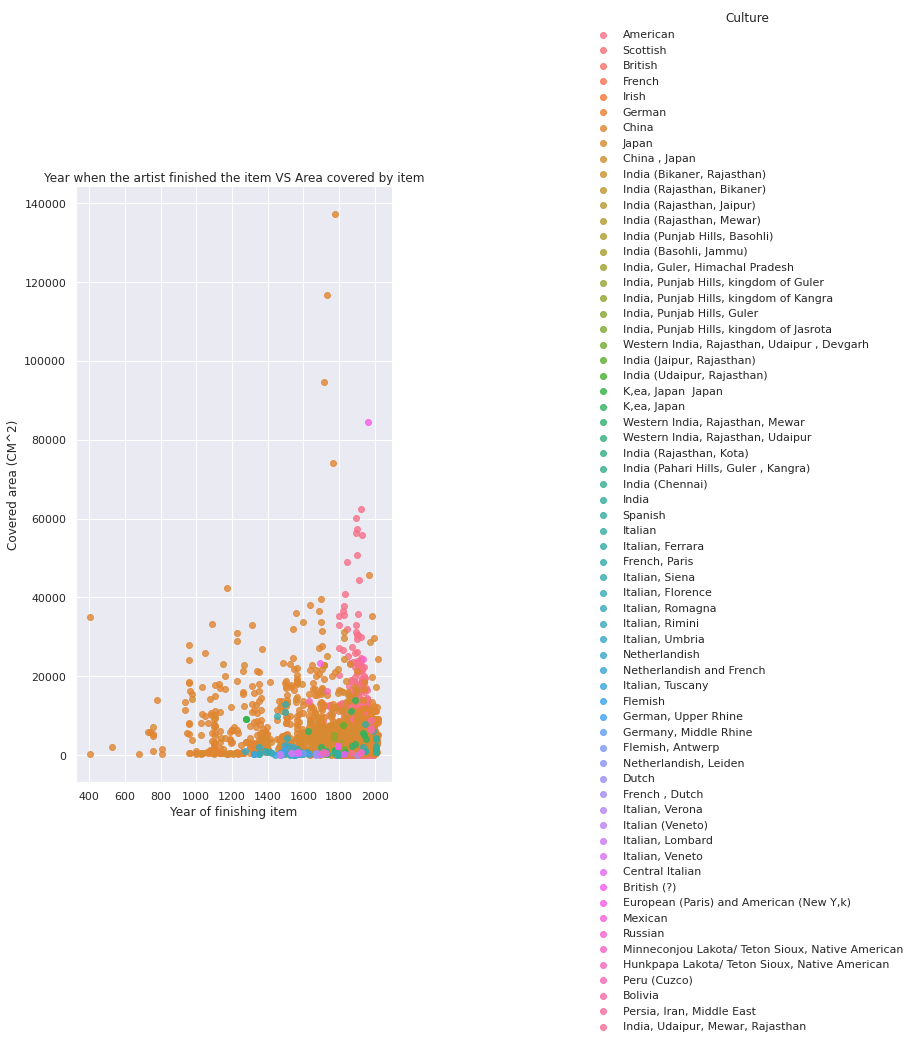

In [ ]:
sns.lmplot('Artist End Date', 'Covered Area', df, hue='Culture', fit_reg=False)
plt.title("Year when the artist finished the item VS Area covered by item")
plt.xlabel("Year of finishing item")
plt.ylabel("Covered area (CM^2)")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

Even though we might have specific preconceived ideas about how quickly drawings are being completed, there is no explicit dependency between the dimension of a painting/drawings and the time spent finishing the artwork.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


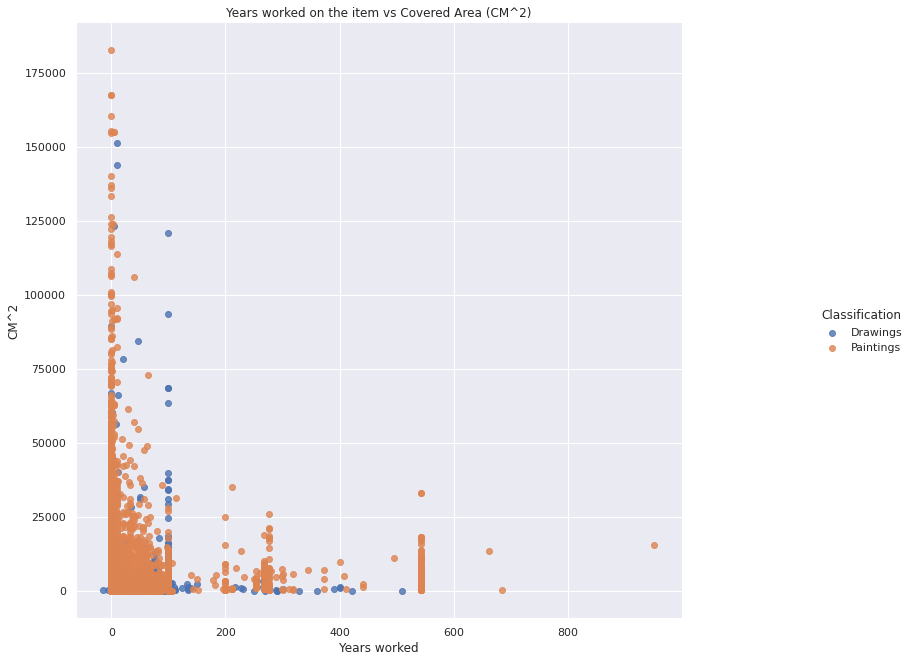

In [ ]:
sns.lmplot('years_worked_item', 'Covered Area', df, hue='Classification', fit_reg=False)
plt.title("Years worked on the item vs Covered Area (CM^2)")
plt.xlabel("Years worked")
plt.ylabel("CM^2")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

# 1.2. **What materials are usually being used ?**

Our project proposal mentioned that we would talk the material into account when performing any analysis. However, this has to be the most diverse column in the entire dataset, and any cleaning procedure is most likely impossible. 

It should be mentioned that these are some of the materials composing the paintings and drawings. For either classification of items, the list is even absurder than this.

Apart from this, we can also mention that there are a lot of multiple values in plenty of the data, which leads to questions that cannot be answered, such as "What percentage of the item is being used by Material X ?"

oil on canvas                             3112
graphite                                   794
graphite on paper                          658
graphite on off-white wove paper           507
oil on wood                                483
watercolor on ivory                        480
ink on paper                               425
pen and brown ink                          349
watercolor                                 334
hanging scroll; ink and color on paper     314
Name: Medium, dtype: int64


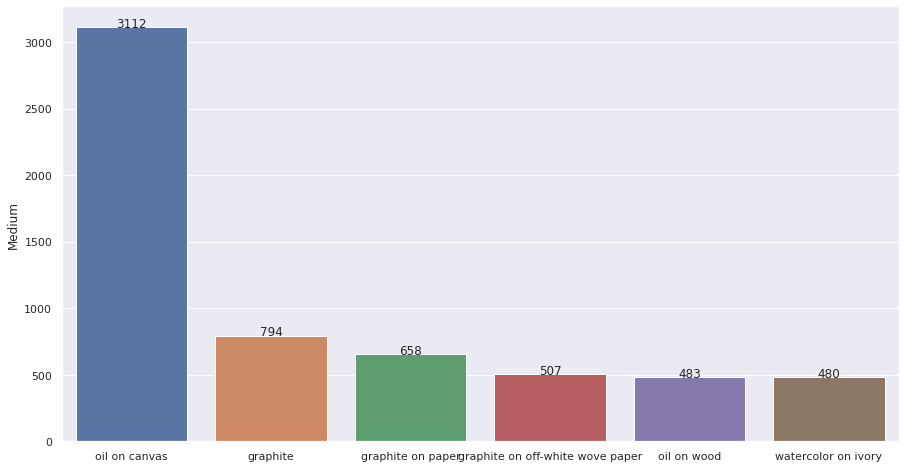

In [ ]:
materials_count = df['Medium'].value_counts()
print(materials_count[0:10])

labels = df['Medium'].value_counts().index
values_count = df['Medium'].value_counts().values

plt.figure(figsize = (15, 8))
ax = sns.barplot(x=labels[:6], y=materials_count[:6])
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.05, materials_count[i],ha="center")

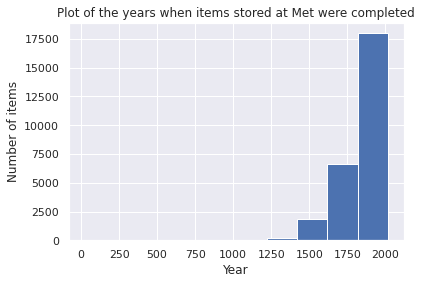

In [ ]:
df["Object End Date"].plot(kind="hist")
plt.title("Plot of the years when items stored at Met were completed")
plt.xlabel("Year")
plt.ylabel("Number of items")
plt.show()

#1.3. **Is a country too poorly represented when referring to the Met Collection? Are artists from a specific country or area underrepresented? Where do most items come from ?**


A kind reminder that only 2% of the items have a "Country" variable. However, in that small dataset, things are clear: American items are by far the most numerous, which is not necessarily a surprising aspect. We are talking about a museum in America, after all. However, the disproportion between American and non-American items does seem too high for such an important museum. 

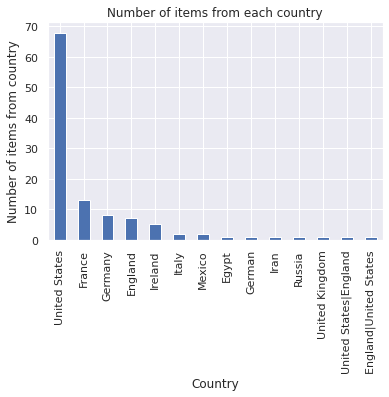

In [ ]:
#Creating a dataframe that would contain all values from the df dataframe, however, would exclude the rows that contain NaN value for a country.
df1 = df[df['Country'].notna()]

df1['Country'].value_counts().plot(kind='bar')
plt.title("Number of items from each country")
plt.xlabel("Country")
plt.ylabel("Number of items from country")
plt.show()

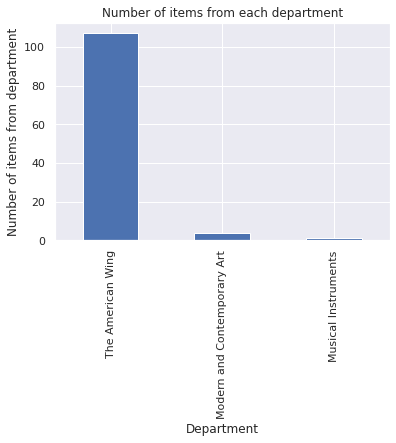

In [ ]:
df1['Department'].value_counts().plot(kind='bar')
plt.title("Number of items from each department")
plt.xlabel("Department")
plt.ylabel("Number of items from department")
plt.show()

As we can observe from the plots above, the values are primarily contained in only one department ( The American Wing). This, of course, leads us to only two conclusions : 
1.   The dataset requires identifications of countries for paintings that are stored in other departments
2.   The collection can be improved by obtaining items from other departments (The American Wing, since it contains the majority of artworks) 

As American artists represent the majority of artworks, we can only conclude that the collection can be improved by importing artworks from other countries. A possible suggestion from those plots would be to expand the collection with artworks from European countries ( France, Germany, England, and Italy) and possibly add some artworks from Asian countries ( China or Japan), as those countries were not presented in the list of countries. However, it could be an interesting additional point to the collection as some artists in the dataset originate from those countries. In our opinion, an immense diversity in artwork origins can provide a broader and better experience for a museum customer, as it shows a complete spectrum over different cultures.

Even though 98% of the items do not have a **"Country"** label, 85% of them do have the artist's nationality. So, we should assume that more valuable geographical information can still be extracted from that field. 

Once we analyze the nationalities of the artists displayed at Met, things look way more balanced than in the previous plot. First, however, we should mention incredible diversity in the **Nationality** field. Most artists have been born in a place and then lived elsewhere (mainly in the U.S.). 
i.e., American|born X

# **One of the research questions in our proposal was: Are we missing items from a particular country or region ?**

While the analysis of the nationalities certainly helps, it is still not a definitive answer to our question. For example, an artist might have very well emigrated to Paris, New York, or London long before he had started working on the item being displayed at Met Museum. Therefore, the nationality alone does not show us precisely which country/region Met museum should focus on to complete its collection.

In [ ]:
# e.g. multiple nationalities
labels_count = df['Artist Nationality'].value_counts()
print(labels_count[22:30])

German|born Switzerland    87
Belgian                    81
American|born Greece       63
British|Scottish           54
Swedish                    32
Indian                     32
American|born Canada       31
American|born Poland       31
Name: Artist Nationality, dtype: int64


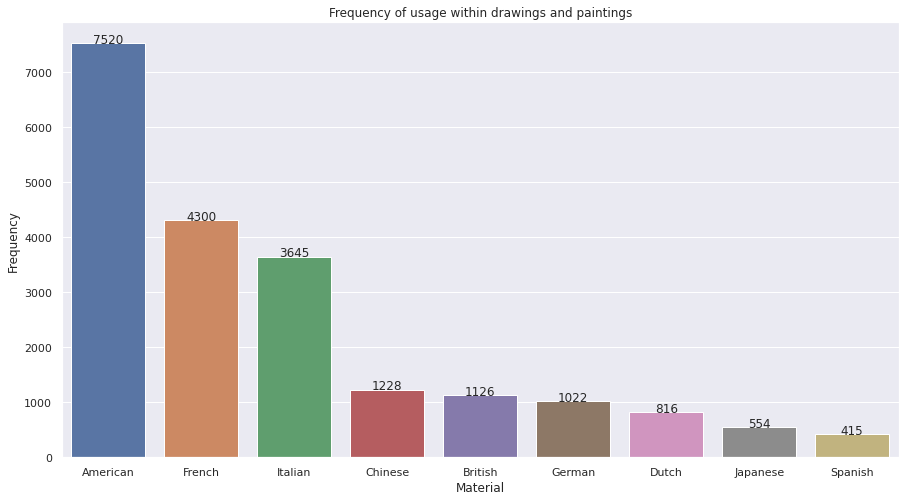

In [ ]:
labels = df['Artist Nationality'].value_counts().index
values = df['Artist Nationality'].value_counts().values

plt.figure(figsize = (15, 8))
ax = sns.barplot(x=labels[:9], y=values[:9])

plt.title("Frequency of usage within drawings and paintings")
plt.xlabel("Material")
plt.ylabel("Frequency")
fig = plt.gcf()

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.05, values[i],ha="center")

Regarding the proportion between paintings and drawings, we can easily notice there's almost 3x more drawings than there are paintings. 

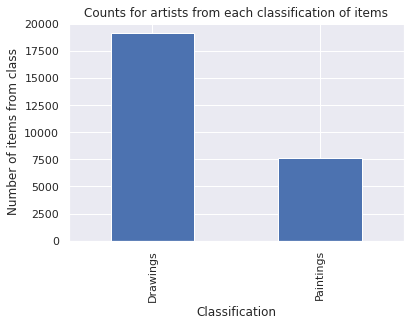

In [ ]:
df['Classification'].value_counts().plot(kind='bar')
plt.title("Counts for artists from each classification of items")
plt.xlabel("Classification")
plt.ylabel("Number of items from class")
plt.show()

In [ ]:
# We have to convert them back to int since they have been converted
# to float throughout the previous operations.
df['Object Begin Date'] = df['Object Begin Date'].astype('Int32')
df['Object End Date'] = df['Object End Date'].astype('Int32')

df['Artist Begin Date'] = df['Artist Begin Date'].astype('Int32')
df['Artist End Date'] = df['Artist End Date'].astype('Int32')

df['years_lived_artist'] = df['years_lived_artist'].astype('Int32')

# del df['years_lived_artist']
# del df['years_worked_item']
df['Artist Begin Date'] = df['Artist Begin Date'].map(int)
df['years_lived_artist'] = df['years_lived_artist'].map(int)

It might not necessarily surprise that the dimensions of **drawings** are way too diverse. For the second part of this analysis, we would like to look at the **paintings** alone and hope to see better-structured data and certain tendencies in our plots. As seen in the previous plot, we continue the following analysis with 7500 (representing the **paintings**) out of the 100.000 items we started with.

In [ ]:
dfp = df.loc[df['Classification'] == 'Paintings']
dfp.head(n = 3)

,Object ID,Department,AccessionYear,Object Name,Title,Culture,Artist Display Name,Artist Nationality,Artist Begin Date,Artist End Date,Artist Wikidata URL,Object Begin Date,Object End Date,Medium,Dimensions,Country,Classification,Object Wikidata URL,Tags,Covered Area,Dimensionality,years_worked_item,years_lived_artist
414,471,The American Wing,1883,Painting,Plaque Portrait of Benjamin Franklin,NaN,Jean-Baptiste Nini,Italian,1717,1786,https://www.wikidata.org/wiki/Q3164318,1776,1883,ivory,6.7x5.1,France,Paintings,https://www.wikidata.org/wiki/Q79024309,Benjamin Franklin|Men|Portraits,34.17,2,107.0,69
428,485,The American Wing,1883,Painting,Portrait of Benjamin Franklin,NaN,H. Sanford,NaN,1783,1822,NaN,1776,1883,panel,13.7x10.8,France,Paintings,https://www.wikidata.org/wiki/Q79023347,Benjamin Franklin|Men|Portraits,147.96,2,107.0,39
3674,3926,The American Wing,1883,Painting,Panel of George Washington,NaN,William P. Babcock,NaN,1826,1899,https://www.wikidata.org/wiki/Q18508740,1846,1883,panel,14x11.4,NaN,Paintings,https://www.wikidata.org/wiki/Q79022461,George Washington|Portraits|Men,159.60,2,37.0,73


In [ ]:
# create a new data frame where we keep unique artists names
artists = dfp.groupby('Artist Display Name', as_index=False).agg(
    count=('Object ID', 'count'), # count how many items each arists has at the Met museum
    total_covered=('Covered Area', sum), # sum their total covered area in the museum
    nationality=('Artist Nationality',
                 lambda x: x.iloc[0]), # add their nationality
    year_born=('Artist Begin Date',
                 lambda x: x.iloc[0]), # the year in which the artist was born
    years_lived=('years_lived_artist',
                 lambda x: x.iloc[0]) # as well as the already computed value representing
                 # the number of years the artist lived for
) # total_worked=('years_worked_item', sum)

# compute average covered area in the artworks created by each artist
artists['Average Covered Area'] = artists.apply(lambda x: x['total_covered'] / x['count'], axis=1)
#dffff['Years Worked Average'] = dffff.apply(lambda x: x['total_worked'] / x['count'], axis=1)

# keep only the artists with at least 2 paintings at Met Museum
artists = artists[artists['count'] > 1]
# sort the values to see the artists with most total covered area
artists.sort_values('total_covered', ascending=False, inplace=True)

In [ ]:
artists.head(n = 3)

,Artist Display Name,count,total_covered,nationality,year_born,years_lived,Average Covered Area
947,Giovanni Battista Tiepolo,20,730376.04,Italian,1696,74,36518.80200
144,Andy Warhol,27,568325.96,American,1928,59,21049.10963
477,Clyfford Still,12,552549.63,American,1904,76,46045.80250


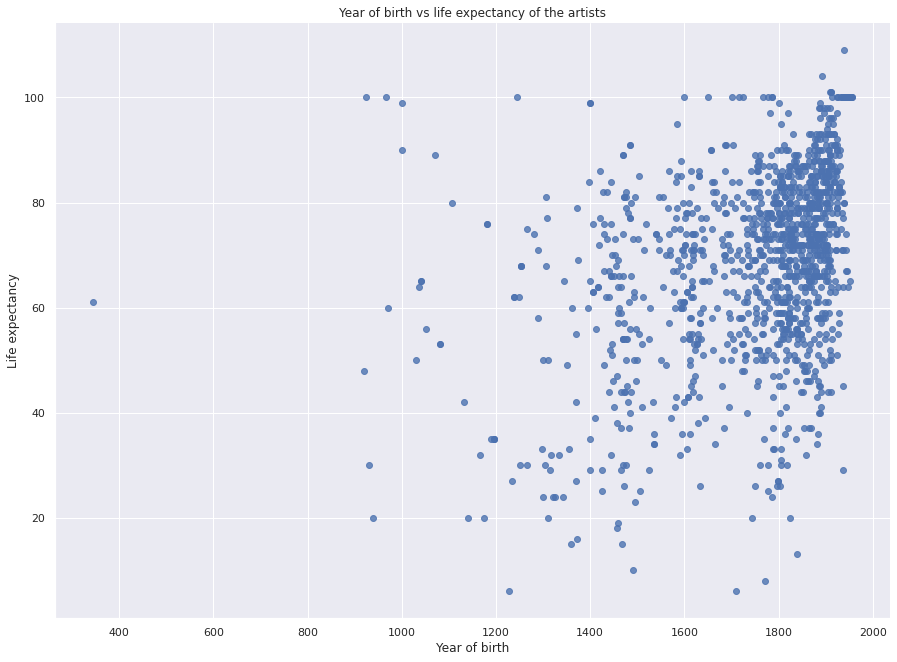

In [ ]:
sns.lmplot(x="year_born", y="years_lived", data=artists, fit_reg=False)
plt.title("Year of birth vs life expectancy of the artists")
plt.xlabel("Year of birth")
plt.ylabel("Life expectancy")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

Indeed, this plot is not telling us anything new. The life expectancies of all humankind have been in a steady increase throughout the last 1000 years. However, I think it would be interesting to create two separate prediction models: trained on our artist data from Met Collection and trained on general data we can find on the internet. By plotting these two prediction lines together, we could conclude matters such as :
"Starting from 1860, American artists have a higher life expectancy than the common American."

Therefore, we will build an OLS model trained on our subset's "year_born" feature of all American painters. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            years_lived   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     37.31
Date:                Tue, 25 Jan 2022   Prob (F-statistic):           3.38e-09
Time:                        14:54:00   Log-Likelihood:                -1132.7
No. Observations:                 281   AIC:                             2269.
Df Residuals:                     279   BIC:                             2277.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -96.8134     28.228     -3.430      0.001    -152.381     -41.246
year_born      0.0921      0.015      6.108      0.000       0.062       0.122
==============================================================================
Omnibus:                       15.616   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.780
Skew:                          -0.592   Prob(JB):                     0.000227
Kurtosis:                       3.170   Cond. No.                     6.48e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

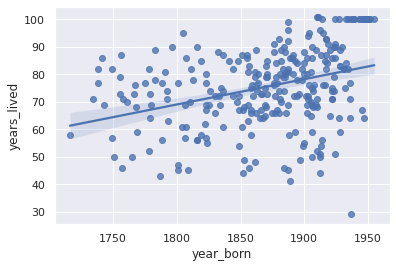

In [ ]:
# For the following comparison, we shall focus only on the American painters and their life expectancies
american_artists = artists[artists['nationality'] == 'American']

life_exp = sm.ols(formula="years_lived ~ year_born", data=american_artists).fit()
sns.regplot(x = 'year_born', y = 'years_lived', data=american_artists)
life_exp.summary()

Therefore, on top of the previous data points and prediction line (Blue), we will be overlapping a second prediction line being trained on the life expectancies of American people starting from the year 1800 (Orange) - information retrieved from an additional dataset found online.

Once we have done this overlapping, one straightforward question emerges:
#1.4. Are the American painters living longer than the average American citizen?

The plot seems more than conclusive. The American painter lived way longer than the average American between 1800 and mid-1900. However, starting from the mid-1900, the life expectancies in the two categories seem to have almost balanced. (It is hard to sure since no American painter born after 1950 has an item displayed at Met Museum).

               Year  Expectancy
Name                           
United States  1800        39.4
United States  1801        39.4
United States  1802        39.4
United States  1803        39.4
United States  1804        39.4


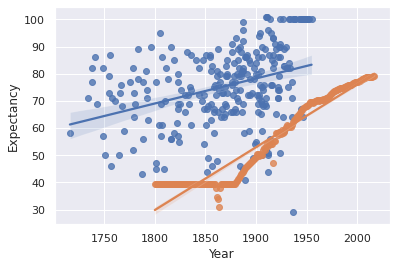

In [ ]:
# Extracted the life expectancies of Americans starting from 1800 from a document retrieved  from
# https://mapipedia.com/s/u/drdave/average_life_expectancy_by_country_since_1800.html

sns.regplot(x = 'year_born', y = 'years_lived', data=american_artists)

american_life_expectancy = pd.read_csv(r"/content/american_life_expectancy.csv", index_col=0, encoding='latin-1')
print(american_life_expectancy.head(n=5))

sns.regplot(x = 'Year', y = 'Expectancy', data=american_life_expectancy);

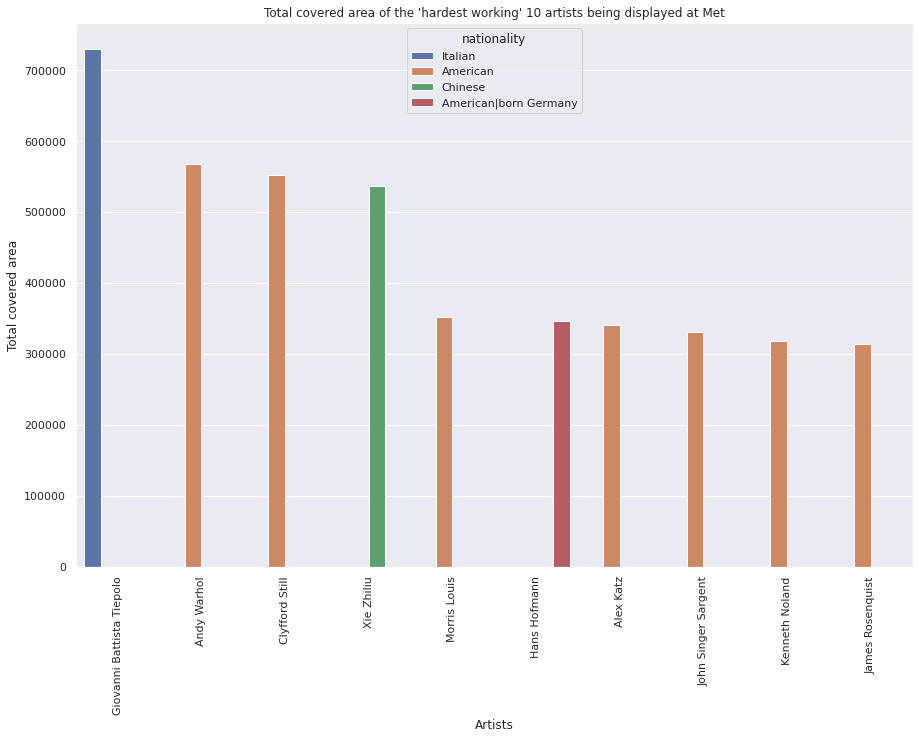

In [ ]:
z=artists.iloc[:10,:] # use the first 10 for the barplot
p=sns.barplot(x='Artist Display Name', y='total_covered', hue='nationality', data=z)
for item in p.get_xticklabels():
    item.set_rotation(90)
plt.title("Total covered area of the 'hardest working' 10 artists being displayed at Met")
plt.xlabel("Artists")
plt.ylabel("Total covered area")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

# 2.0. There is one more thing we wish to do with this subset representing the **Paintings** at the Met Museum: To compute the total covered dimension and average covered depending on the **Object End Date** (i.e., the year when the item was completed). 

We are mainly interested in 2 aspects: 

1. To see if there is a clear trend in how the dimensions of paintings are changing (i.e., is the **average covered area** increasing over the years ?). A prediction model shall be learned to predict this trend for the years to come.

2. Which years are the best represented in the Met Collection? (* assuming for this sake that a bigger painting represents better year X than a smaller painting represents year Y)


In [ ]:
# create another dataframe where keeping each year and its statistics
df_years = dfp.groupby('Object End Date', as_index=False).agg(
    count=('Object ID', 'count'), # how many objects were created that year
    total_covered=('Covered Area', sum)) # total covered area of the objects created that year
df_years['Average Covered Area'] = df_years.apply(lambda x: x['total_covered'] / x['count'], axis=1)

#df_years['Years'] = df_years.index
df_years.sort_values('total_covered', ascending=False, inplace=True)
df_years.head(5)

,Object End Date,count,total_covered,Average Covered Area
551,1911,140,977007.27,6978.623357
624,1984,23,946641.47,41158.324783
622,1982,27,840832.17,31141.932222
623,1983,30,737892.76,24596.425333
608,1968,19,710496.44,37394.549474


# 2.1 Is there a clear trend in how the average dimension changes over the years?

As seen in the following plot, there is a slight increasing trend in the average dimensions of paintings. Therefore, in theory, such a model could be helpful to the museum if it wishes to extend an existing wing or even build a new one to make sure there is enough room for the artwork to be collected in the coming years. 

     Object End Date  count  total_covered  Average Covered Area
551             1911    140      977007.27           6978.623357
624             1984     23      946641.47          41158.324783
622             1982     27      840832.17          31141.932222
623             1983     30      737892.76          24596.425333
608             1968     19      710496.44          37394.549474


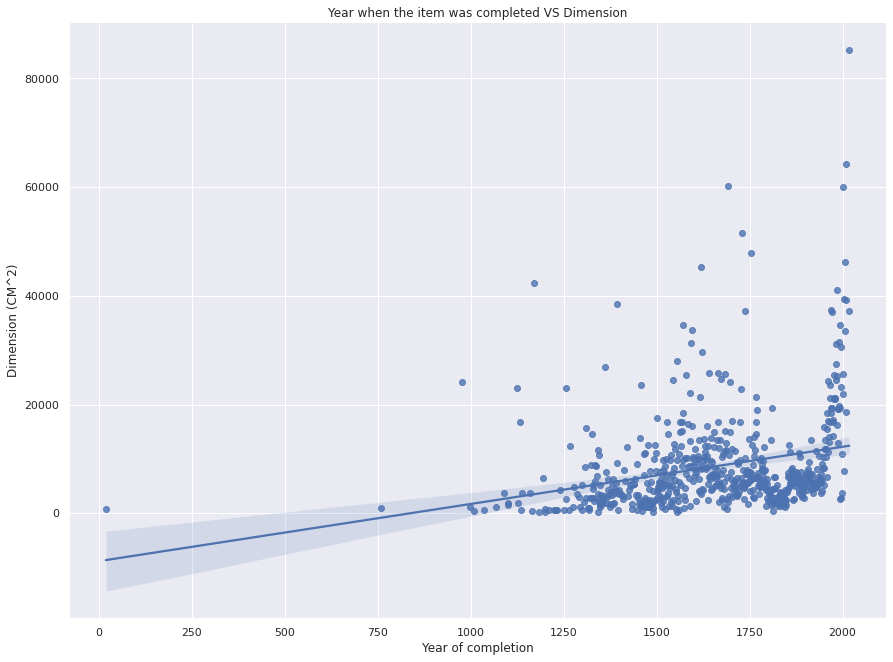

In [ ]:
s= df_years.sort_values(by=['Average Covered Area'], ascending=False)

print(df_years[0:5])

# Let us take into account only the years when at least two items were completed
df_years_count = df_years[df_years['count'] > 1].count()

sns.lmplot(x="Object End Date", y="Average Covered Area", data=df_years, fit_reg=True)
plt.title("Year when the item was completed VS Dimension")
plt.xlabel("Year of completion")
plt.ylabel("Dimension (CM^2)")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

Even though there is a somewhat increasing trend in the average dimension, the 

Values are especially scattered, making it impossible to build a quality predictive model. 

The model does not stand any chance of fitting the data very well. 


In [ ]:
X = pd.DataFrame(df_years['Object End Date'])
Y = df_years['Average Covered Area']

model = Ridge(normalize = True)
    
cross_valid = RepeatedKFold(n_splits = 4, n_repeats = 20, random_state = 1)
grid = dict()
grid['alpha'] = arange(0, 1, 0.001)

search = GridSearchCV(model, grid, scoring = 'neg_mean_absolute_error', n_jobs = -1)
model = search.fit(X, Y)

print('MAE: %.3f' % model.best_score_)
print('Config: %s' % model.best_params_)

MAE: -6043.310
Config: {'alpha': 0.105}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


# Slightly regularized Ridge Model vs Baseline Linear Regression model

In [ ]:
# Ridge Model (alpha = 0.105) VS Linear Regression

X_train, X_test , Y_train, Y_test = train_test_split(X, Y, test_size = 0.34, random_state = 2)

model_ridge = Ridge(alpha = 0.105, normalize = True)
model_ridge.fit(X_train, Y_train)        
pred1 = model_ridge.predict(X_test)    
pred1Train = model_ridge.predict(X_train)
print('Comparison of Ridge model using the optimal alpha previously found VS Simple Linear Regression Model:')
print('Validation slightly regularized MSE Ridge: %.3f' % mean_squared_error(Y_test, pred1))   
print('Training slighlty regularized MSE Ridge: %.3f' % mean_squared_error(Y_train, pred1Train))   
print('---------------------------------------')

## Simple Linear Regression model ###############

linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, Y_train)
linear_model2 = linear_reg_model.predict(X_test)  
linear_model_train = linear_reg_model.predict(X_train)  
print('Validation Baseline MSE Linear: %.3f' % mean_squared_error(Y_test, linear_model2))   
print('Training Baseline MSE Linear: %.3f' % mean_squared_error(Y_train, linear_model_train))

Comparison of Ridge model using the optimal alpha previously found VS Simple Linear Regression Model:
Validation slightly regularized MSE Ridge: 95558735.481
Training slighlty regularized MSE Ridge: 70152302.789
---------------------------------------
Validation Baseline MSE Linear: 95854996.761
Training Baseline MSE Linear: 70084129.164


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


As insignificant as that regularization might have been, the Ridge model slightly outperforms the baseline Linear Regression model.

# 2.2 Which years are the best represented in the Met Collection?

According to the Met Collection, 1984 and 1911 were by far the most productive year in terms of the total painted area. 

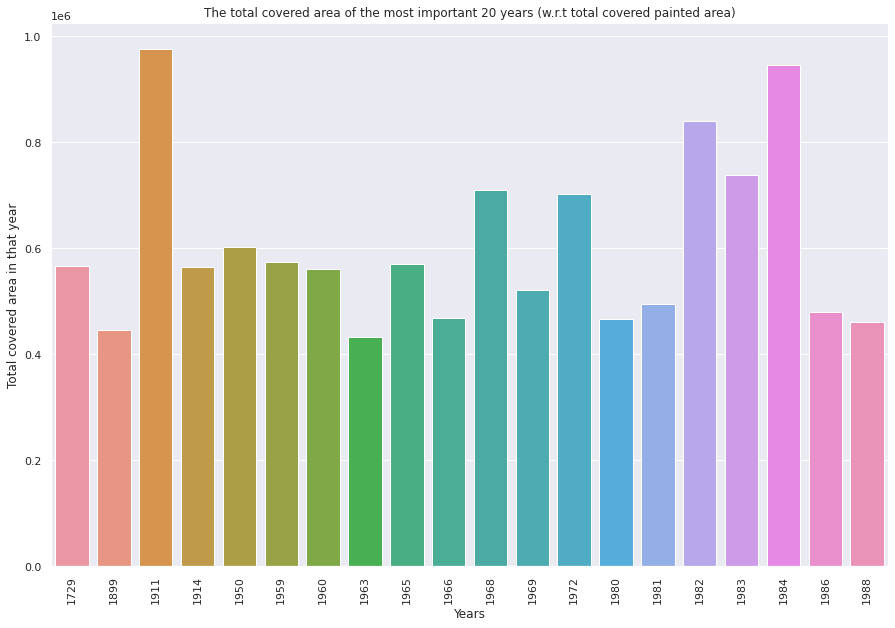

In [100]:
df_years=df_years.sort_values(by=['total_covered'], ascending=False)
y=df_years.iloc[:20,:] # use the first 20 for the barplot
p=sns.barplot(x='Object End Date', y='total_covered', data=y)
for item in p.get_xticklabels():
    item.set_rotation(90)
plt.title("The total covered area of the most important 20 years (w.r.t total covered painted area)")
plt.xlabel("Years")
plt.ylabel("Total covered area in that year")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

#2.3 How about the most productive years ?

On the other hand, there are plenty of years when no painting has been finished, at least not one currently being stored at the Met museum.

However, among the years that are present in our remaining subset, the area of paintings completed in the years 1200 and 1341 seems to have been the most modest.

Just to get a better idea, there is 4166.6x times more painted area from the most fruitful year (1911) than there is in the least productive one (1341). 

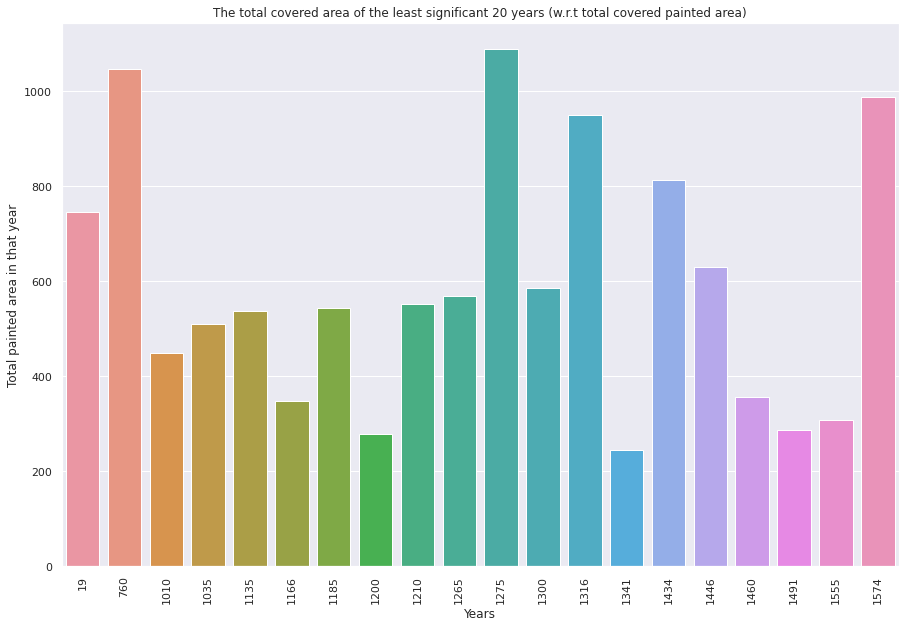

In [101]:
df_years=df_years.sort_values(by=['total_covered'], ascending=True)
y=df_years.iloc[:20,:] # use the first 20 for the barplot
p=sns.barplot(x='Object End Date', y='total_covered', data=y)
for item in p.get_xticklabels():
    item.set_rotation(90)
plt.title("The total covered area of the least significant 20 years (w.r.t total covered painted area)")
plt.xlabel("Years")
plt.ylabel("Total painted area in that year")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()